<a href="https://colab.research.google.com/github/DaryaTereshchenko/HateSpeechDetection/blob/main/Pytorch_TF_Embed_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sentence_transformers
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, TextVectorization, Input

In [ ]:
ethos_hate = pd.read_csv("https://raw.githubusercontent.com/DaryaTereshchenko/HateSpeechDetection/main/ethos_data/ethos_hate.csv", sep=",", encoding="unicode_escape").drop(columns="label")
ethos_hate["label"] = 1

ethos_neutral = pd.read_csv("https://raw.githubusercontent.com/DaryaTereshchenko/HateSpeechDetection/main/ethos_data/ethos_neutral.csv", sep=",", encoding="unicode_escape").drop(columns="label")
ethos_neutral["label"] = 0

train_n = ethos_neutral.sample(frac=0.9, random_state=0)
test_n = ethos_neutral.drop(train_n.index)

train_hate = ethos_hate.sample(frac=0.9, random_state=0)
test_hate = ethos_hate.drop(train_hate.index)

train = pd.concat([train_n, train_hate]).sample(frac=1, random_state=300).reset_index(drop=True)
test = pd.concat([test_n, test_hate]).sample(frac=1, random_state=300).reset_index(drop=True)



What episode number was this?


In [ ]:
csv_file_hate = 'https://raw.githubusercontent.com/DaryaTereshchenko/HateSpeechDetection/main/ethos_data/ethos_sm_hate.csv'
csv_file_neutral = 'https://raw.githubusercontent.com/DaryaTereshchenko/HateSpeechDetection/main/ethos_data/ethos_sm_neutral.csv'
tsv = 'https://raw.githubusercontent.com/DaryaTereshchenko/HateSpeechDetection/main/ethos_data/hurtlex_EN.tsv'

hate_speech = pd.read_csv(csv_file_hate, sep=";", decimal=",", skiprows=[1,2,3,4], low_memory=False, on_bad_lines='skip').sort_values(by=["CODE"])
neutral_speech = pd.read_csv(csv_file_neutral, sep=";", decimal=",", skiprows=[1,2,3,4], low_memory=False, on_bad_lines='skip').sort_values(by=["CODE"])

hate_speech = hate_speech.drop(columns="CODE")
neutral_speech = neutral_speech.drop(columns="CODE")

In [ ]:
train_sm_n = neutral_speech.sample(frac=0.9, random_state=0)
test_sm_n = neutral_speech.drop(train_sm_n.index)

train_sm_hate = hate_speech.sample(frac=0.9, random_state=0)
test_sm_hate = hate_speech.drop(train_sm_hate.index)

TrainSM = pd.concat([train_sm_n, train_sm_hate]).sample(frac=1, random_state=300).reset_index(drop=True)
TestSM = pd.concat([test_sm_n, test_sm_hate]).sample(frac=1, random_state=300).reset_index(drop=True)

# Use with PyTorch

In [ ]:
! pip install pytorch_lightning

In [ ]:
from transformers import RobertaTokenizer, RobertaModel, set_seed

MAIN_DIR = ''
MODEL_DIR = ''
MODEL_NAME = 'roberta-base'

tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
bert = RobertaModel.from_pretrained(MODEL_NAME)


In [ ]:
import os
import random

import numpy as np
import torch
from sklearn.utils.class_weight import compute_class_weight
from transformers import set_seed as transformers_ss

from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix




def set_seed(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    transformers_ss(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


def get_class_weights(train_labels, device):
    # compute the class weights
    class_weights = compute_class_weight(
        class_weight="balanced", classes=np.unique(train_labels), y=train_labels
    )
    # converting list of class weights to a tensor
    weights = torch.tensor(class_weights, dtype=torch.float)
    # push to GPU
    return weights.to(device)


def plot_cm(
    y_true,
    y_pred,
    normalize,
    labels=None,
    save=False,
    directory=None,
    filename=None,
    title="",
    cmap=plt.cm.Blues,
):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=cmap)
    plt.title(title)
    if save:
        directory = Path(directory)
        directory.mkdir(parents=True, exist_ok=True)
        plt.savefig(directory / filename)
        plt.close()
    else:
        plt.show()


In [ ]:
import json
import math
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import metrics
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AdamW,
    PreTrainedTokenizerFast,
    RobertaModel,
    get_cosine_schedule_with_warmup,
)


N_STYLO_FEATURES = 157
HIDDEN_UNITS = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class UCC_Dataset(Dataset):
    def __init__(
        self,
        data,
        text_column,
        stylo_column,
        tokenizer,
        target_column,
        max_token_len: int = 128,
        sample=5000,
    ):
        self.data = data
        self.text_column = text_column
        self.tokenizer = tokenizer
        self.target_column = target_column
        self.stylo_column = stylo_column
        self.max_token_len = max_token_len
        self.sample = sample
        try:
            dummy_df = pd.get_dummies(self.data[self.target_column], prefix="class")
            self.data = self.data.merge(dummy_df, left_index=True, right_index=True)
            self.one_hot_cols = dummy_df.columns
        except KeyError:
            self.one_hot_cols = []

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data.iloc[index]
        text = str(item[self.text_column])
        attributes = torch.FloatTensor(item[self.one_hot_cols])

        tokens = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=self.max_token_len,
            return_attention_mask=True,
        )
        X_stylo = self.data[self.stylo_column].iloc[index]
        X_stylo = torch.tensor(X_stylo).type(torch.float32)
        return {
            "input_ids": tokens.input_ids.flatten(),
            "attention_mask": tokens.attention_mask.flatten(),
            "labels": attributes,
            "stylo_metrix": X_stylo,
        }


class UCC_Data_Module(pl.LightningDataModule):
    def __init__(
        self,
        train_df,
        val_df,
        text_column,
        stylo_column,
        target_column,
        tokenizer,
        model,
        batch_size: int = 16,
        max_token_length: int = 128,
    ):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.text_column = text_column
        self.stylo_column = stylo_column
        self.target_column = target_column
        self.tokenizer = tokenizer
        self.model = model
        self.batch_size = batch_size
        self.max_token_length = max_token_length

    def setup(self, stage=None):
        if stage in (None, "fit"):
            self.train_dataset = UCC_Dataset(
                self.train_df,
                self.text_column,
                self.stylo_column,
                self.tokenizer,
                self.target_column,
            )
            self.val_dataset = UCC_Dataset(
                self.val_df,
                self.text_column,
                self.stylo_column,
                self.tokenizer,
                self.target_column,
                sample=None,
            )
        if stage == "predict":
            self.val_dataset = UCC_Dataset(
                self.val_df,
                self.text_column,
                self.stylo_column,
                self.tokenizer,
                self.target_column,
                sample=None,
            )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, num_workers=4, shuffle=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=self.batch_size, num_workers=4, shuffle=False
        )

    def predict_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=self.batch_size, num_workers=4, shuffle=False
        )


class UCC_Comment_Classifier(pl.LightningModule):
    def __init__(self, config: dict):
        super().__init__()
        self.config = config
        self.pretrained_roberta = config["roberta_model"]
        self.hidden = torch.nn.Linear(
            self.pretrained_roberta.config.hidden_size + N_STYLO_FEATURES,
            self.pretrained_roberta.config.hidden_size + N_STYLO_FEATURES,
        )
        self.classifier = torch.nn.Linear(
            self.pretrained_roberta.config.hidden_size + N_STYLO_FEATURES,
            self.config["n_labels"],
        )
        torch.nn.init.xavier_uniform_(self.classifier.weight)
        self.loss_func = nn.BCEWithLogitsLoss(
            pos_weight=config["class_weights"], reduction="mean"
        )
        self.dropout = nn.Dropout()

    def forward(self, input_ids, attention_mask, stylo_metrix, labels=None):
        # roberta layer
        output = self.pretrained_roberta(
            input_ids=input_ids, attention_mask=attention_mask, return_dict=True
        )
        pooled_output = torch.mean(output.last_hidden_state, 1)
        pooled_output = torch.cat((pooled_output, stylo_metrix), dim=1)
        # final logits
        pooled_output = self.dropout(pooled_output)
        pooled_output = self.hidden(pooled_output)
        pooled_output = F.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        # calculate loss
        loss = 0
        if labels is not None:
            loss = self.loss_func(
                logits.view(-1, self.config["n_labels"]),
                labels.view(-1, self.config["n_labels"]),
            )
        return loss, logits

    def training_step(self, batch, batch_index):
        loss, outputs = self(**batch)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": batch["labels"]}

    def validation_step(self, batch, batch_index):
        loss, outputs = self(**batch)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return {"val_loss": loss, "predictions": outputs, "labels": batch["labels"]}

    def predict_step(self, batch, batch_index):
        del batch["labels"]
        _, outputs = self(**batch)
        return outputs

    def configure_optimizers(self):
        optimizer = AdamW(
            self.parameters(),
            lr=self.config["lr"],
            weight_decay=self.config["weight_decay"],
        )
        total_steps = self.config["train_size"] / self.config["batch_size"]
        warmup_steps = math.floor(total_steps * self.config["warmup"])
        warmup_steps = math.floor(total_steps * self.config["warmup"])
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, warmup_steps, total_steps
        )
        return [optimizer], [scheduler]


# This class defines the model that was used to pre-train a SNN on TF-IDF features
class Stylo_Nn(pl.LightningModule):
    def __init__(self, config):
        super().__init__()

        self.config = config
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(N_STYLO_FEATURES, HIDDEN_UNITS)
        # Output layer
        self.output = nn.Linear(HIDDEN_UNITS, config["n_labels"])
        self.dropout = nn.Dropout(0.1)

        # Defining tanh activation and softmax output
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

        # Defining loss function
        self.loss_func = nn.BCEWithLogitsLoss(reduction="mean")

    def forward(self, stylo_metrix, input_ids=None, attention_mask=None, labels=None):
        # Pass the input tensor through each of our operations
        stylo_metrix = self.hidden(stylo_metrix)
        # print(x.shape)
        hidden = F.relu(stylo_metrix)
        # print(y.shape)
        output = self.dropout(hidden)
        # print(z.shape)
        output = self.output(output)
        # print(z.shape)
        output = self.softmax(output)

        # Returning the ouputs from the hidden layer and the final output layer
        # calculate loss
        loss = 0
        if labels is not None:
            loss = self.loss_func(
                output.view(-1, self.config["n_labels"]),
                labels.view(-1, self.config["n_labels"]),
            )
        return loss, hidden, output

    def training_step(self, batch, batch_index):
        loss, hidden, outputs = self(**batch)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": batch["labels"]}

    def validation_step(self, batch, batch_index):
        loss, hidden, outputs = self(**batch)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return {"val_loss": loss, "predictions": outputs, "labels": batch["labels"]}

    def predict_step(self, batch, batch_index):
        del batch["labels"]
        _, _, outputs = self(**batch)
        return outputs

    def configure_optimizers(self):
        optimizer = AdamW(
            self.parameters(),
            lr=0.1,  # 0.01,  # TODO: dodać do configu
            weight_decay=self.config["weight_decay"],
        )
        total_steps = self.config["train_size"] / self.config["batch_size"]
        warmup_steps = math.floor(total_steps * self.config["warmup"])
        warmup_steps = math.floor(total_steps * self.config["warmup"])
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, warmup_steps, total_steps
        )
        return [optimizer], [scheduler]


# method to convert list of comments into predictions for each comment
def classify_raw_comments(model, dm, trainer):
    predictions = trainer.predict(model, datamodule=dm)
    flattened_predictions = np.stack(
        [torch.sigmoid(torch.Tensor(p)) for batch in predictions for p in batch]
    )
    return flattened_predictions


def load_model(checkpoint_path, config):
    tokenizer = PreTrainedTokenizerFast(
        tokenizer_file=f"{config['roberta_model']}/tokenizer.json"
    )
    tokenizer.pad_token_id = 1
    bert = RobertaModel.from_pretrained(
        str(config["roberta_model"]), output_hidden_states=True
    )

    config["roberta_model"] = bert
    config["class_weights"] = torch.tensor(config["class_weights"])
    model = UCC_Comment_Classifier(config)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["state_dict"])
    return tokenizer, bert, model



In [ ]:
train

,text,label
0,What episode number was this?,0
1,Why don't you go beck your god to murder you? ...,1
2,"I don't like jew soap, but if we are to get ri...",1
3,"By calling period, a natural procedure, as an ...",1
4,MASS BLACK WORLDWIDE GENOCIDE IS OUR ONLY HOPE,1
...,...,...
893,Is this world filled by those stupid female bi...,1
894,What type of question it is???????,0
895,Die fucking arab dude sand niggas,1
896,Japanese culture is ancient and unique,0


In [ ]:
train['stylo_metrix'] = list(TrainSM.values)

In [ ]:
train

,text,label,stylo_metrix
0,What episode number was this?,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Why don't you go beck your god to murder you? ...,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"I don't like jew soap, but if we are to get ri...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"By calling period, a natural procedure, as an ...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,MASS BLACK WORLDWIDE GENOCIDE IS OUR ONLY HOPE,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
893,Is this world filled by those stupid female bi...,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
894,What type of question it is???????,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
895,Die fucking arab dude sand niggas,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
896,Japanese culture is ancient and unique,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
test['stylo_metrix'] = list(TestSM.values)

In [ ]:
validation = train.sample(frac=0.15, random_state=0)
train = train[~train.index.isin(validation.index)]

In [ ]:
text_column, class_column, stylo_column = (
      "text",
      "label",
      "stylo_metrix",
  )
model_path =  Path("./checkpoints")
filepath = "/mnt/kingagl/projects/komtur_text/data/data_frames/entries_comments_nowe_stylo_ROBERTA_SM_Lemma_4.pickle"
model_name = "model_roberta_stylo"
checkpoint_path = model_path / f"{model_name}.ckpt"
model_path.mkdir(parents=True, exist_ok=True)

train_df = train.copy()
val_df = validation.copy()
test_df = test.copy()

torch.cuda.empty_cache()

config = {
    "roberta_model": bert,
    "n_labels": len(train_df[class_column].unique()),
    "labels": list(pd.get_dummies(train_df[class_column]).columns),
    "class_weights": get_class_weights(train_df[class_column], device),
    "batch_size": 16,
    "lr": 1.5e-6,
    "warmup": 0.2,
    "train_size": train_df.shape[0],
    "weight_decay": 0.001,
    "n_epochs": 20,
}

# datamodule
ucc_data_module = UCC_Data_Module(
    train_df,
    val_df,
    text_column,
    stylo_column,
    class_column,
    tokenizer,
    bert,
    batch_size=config["batch_size"],
)
ucc_data_module.setup()






In [ ]:
# model
# stylo_model = Stylo_Nn(config)
model = UCC_Comment_Classifier(config)

# trainer and fit
checkpoint_callback = ModelCheckpoint(
    dirpath=model_path,
    filename=model_name,
    monitor="val_loss",
)
earlystopping_callback = EarlyStopping(monitor="val_loss", mode="min")

trainer = pl.Trainer(
    max_epochs=config["n_epochs"],
    gpus=1,
    num_sanity_val_steps=50,
    callbacks=[checkpoint_callback, earlystopping_callback],
)

trainer.fit(model, ucc_data_module)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  war

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 41it [00:00, ?it/s]

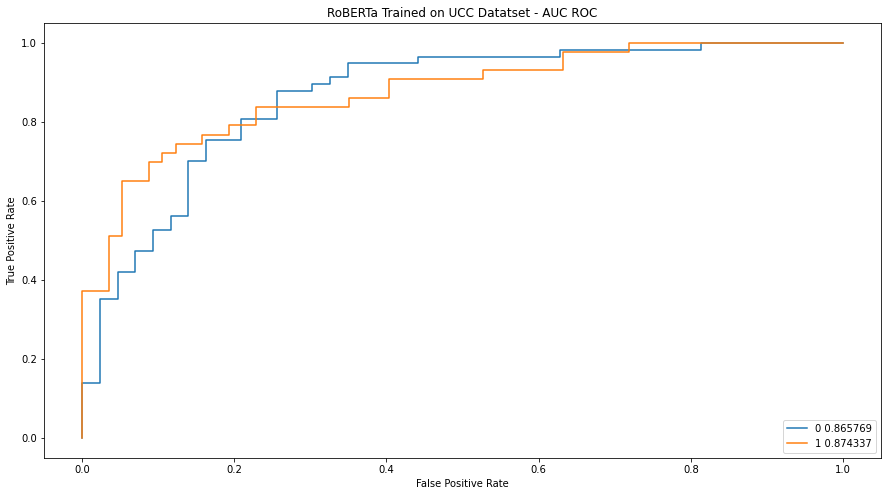

              precision    recall  f1-score   support

           0       0.83      0.79      0.81        57
           1       0.74      0.79      0.76        43

    accuracy                           0.79       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.79      0.79      0.79       100



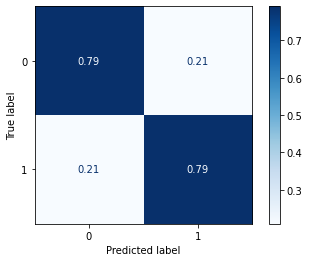

In [ ]:
ucc_test_data_module = UCC_Data_Module(
    pd.DataFrame(columns=test_df.columns),
    test_df,
    text_column,
    stylo_column,
    class_column,
    tokenizer,
    config["roberta_model"],
)

predictions = classify_raw_comments(model, ucc_test_data_module, trainer)

true_labels = pd.get_dummies(test_df[class_column]).values

plt.figure(figsize=(15, 8))
for i, attribute in enumerate(model.config["labels"]):
    fpr, tpr, _ = metrics.roc_curve(
        true_labels[:, i].astype(int), predictions[:, i]
    )
    auc = metrics.roc_auc_score(true_labels[:, i].astype(int), predictions[:, i])
    plt.plot(fpr, tpr, label="%s %g" % (attribute, auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title("RoBERTa Trained on UCC Datatset - AUC ROC")

plt.show()

print(
    metrics.classification_report(
        true_labels.argmax(axis=1), predictions.argmax(axis=1)
    )
)
plot_cm(
    true_labels.argmax(axis=1),
    predictions.argmax(axis=1),
    "true",
    labels=model.config["labels"]
)

